# Problem Set 3 (First Model Runs)

## MACS 31300: AI Applications in Social Sciences

### Ishan Nagpal and Mingtao Gao

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

#### Data Cleaning and Spliting

In [2]:
def df_clean():   
    path = '/Users/ivnagpal/Desktop/Enron Final Project/MACS31300_Final_Project'
    os.chdir(path)
    df = pd.read_csv (r'enron.csv')
    df = df.drop(columns=['email_address','position']) 
    df = df.fillna(df.mean())
    return df
    
df = df_clean()

#Freatures
x = df.drop (columns = ['insider','POI'])

#Labels
y = df[['POI']]

We drop the columns containing insider's email addreses, names, and position in Enron  because they are not useful in predicting whether the insider is POI. Further, we replace the missing values for the retained features with its mean. We then split the dataframe into a dataframe containing features and POI.

In [3]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state= 40)
print ('Number of training samples:', len (x_train), 'Observations')
print ('Number of test samples:', len (x_test), 'Observations')

Number of training samples: 100 Observations
Number of test samples: 44 Observations


70% and 30% of the 144 observation are randomly placed in training and testing dataframes respectively for modeling.

#### Runing Bagging Tree Classifier

In [4]:
bag = BaggingClassifier(DecisionTreeClassifier(),n_estimators = 20, oob_score= True,random_state = 40)
bag.fit(x_train,y_train)
decision_function = bag.oob_decision_function_
print ('\nTraining Data Accuracy Score:', bag.score(x_train, y_train))
print ("Decision Function Array:\n", decision_function)


Training Data Accuracy Score: 0.99
Decision Function Array:
 [[0.         1.        ]
 [1.         0.        ]
 [0.57142857 0.42857143]
 [0.71428571 0.28571429]
 [1.         0.        ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.18181818 0.81818182]
 [0.88888889 0.11111111]
 [1.         0.        ]
 [0.6        0.4       ]
 [1.         0.        ]
 [1.         0.        ]
 [0.85714286 0.14285714]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.6        0.4       ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.88888889 0.11111111]
 [0.71428571 0.28571429]
 [0.5        0.5       ]
 [0.88888889 0.11111111]
 [0.90909091 0.09090909]
 [1.         0.        ]
 [1.         0.        ]
 [0.33333333 

Our bagging tree classifier takes bootstrapped samples of the test data to generate 20 decision trees. It then determines whether the observation is a "POI" based on the most popular outcome when running the attributes through all randomly generated decision trees. We obtain a Training Data Accuracy score of 0.99 suggesting overfitting, which could lead to poor generalization of test data. Previewed above is our model's decision function array. For each observation, when the value in the first column is larger than the second, the bagging tree classifies the observation as not a POI. Conversely, when the observation in the second column is larger than the first, the bagging tree classifies the observation as a POI.

#### Predict Labels of Test Data using Bagging Tree Classifier

In [5]:
y_bagp = bag.predict(x_test)
y_prob = bag.predict_proba(x_test)
print ('First 10 Test Prediction Values:\n', y_bagp[0:10])
print ('\nFirst 10 Test Probability Values:\n', y_prob[0:10])

First 10 Test Prediction Values:
 ['No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'Yes']

First 10 Test Probability Values:
 [[1.   0.  ]
 [1.   0.  ]
 [0.7  0.3 ]
 [0.55 0.45]
 [1.   0.  ]
 [0.95 0.05]
 [0.9  0.1 ]
 [1.   0.  ]
 [1.   0.  ]
 [0.35 0.65]]


We run the the test data frame through the bagging tree classifier (20 Random generated trees) to obtain "POI" predictions. We print the first 10 predictions, where a "No" value indicates that the insider is not a POI, and vice versa. We also print the probability estimates, which highlight the results of each observation when they are run through the random forest. When the probability value in the second column is greater than the first, the model labels the observation as a POI and vice versa.

#### Accuracy Metrics

In [6]:
#Accuracy Score
print("Accuracy:", round (metrics.accuracy_score(y_test, y_bagp),4))

#Confusion Matrix
print('\nConfusion Matrix:\n',confusion_matrix(y_test, y_bagp))

Accuracy: 0.8182

Confusion Matrix:
 [[35  2]
 [ 6  1]]


We find that the bagging tree classifier accurately predicts the correct POI/non-POI label 81.82% of the time (36/44). The confusion matrix suggests that the model predicted 35 out of 37 non-POI observations (94.59%) and 1 out 7 POI observations (14.29%). We are troubled with the model's relatively poor job predicting POI, which we attribute to the decision tree's being ovefitted. To create a more generalized model, we hypertune the parameters.

#### Hyperparameter Tuning

In [14]:
param_grid = {'criterion':['gini','entropy'],'max_depth':range(1,10),
             'min_samples_split':range(1,10),
              'min_samples_leaf':range(1,5)}
gs = GridSearchCV(DecisionTreeClassifier(),param_grid,cv=10,verbose=1,n_jobs=-1)
gs.fit(x_train, y_train)
gs.best_estimator_ #Optimized parameters

Fitting 10 folds for each of 648 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:    7.2s finished


DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=3)

To generalize the model, we engage in hyperparameter tuning, utilizing a gridsearchcv, to optimize the following paramters: criterion for measuing split quality, maximum depth of the tree, and the minimum number of observations required to split a node. https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html. The gridsearch algorithm suggests a decision tree which uses an'entropy' measure in deciding whether to split, a maximize tree depth of 6, and a minuimum of 3 observations in a node to split.

#### Runing Bagging Tree Classifier Using Hyperparameter Tuning

In [17]:
bag_h = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=3),n_estimators = 20, oob_score= True,random_state = 40)
bag_h.fit(x_train,y_train)
decision_function_g = bag.oob_decision_function_
print ('\nTraining Data Accuracy Score:', bag_h.score(x_train, y_train))
y_bagp_h = bag_h.predict(x_test)
y_prob_h = bag_h.predict_proba(x_test)
print ('First 10 Test Prediction Values:\n', y_bagp_h[0:10])
print ('\nFirst 10 Test Probability Values:\n', y_prob_h[0:10])


Training Data Accuracy Score: 0.98
First 10 Test Prediction Values:
 ['No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No']

First 10 Test Probability Values:
 [[1.     0.    ]
 [1.     0.    ]
 [0.6    0.4   ]
 [0.75   0.25  ]
 [1.     0.    ]
 [0.9    0.1   ]
 [0.75   0.25  ]
 [1.     0.    ]
 [1.     0.    ]
 [0.5125 0.4875]]


In [16]:
#Accuracy Score
print("Accuracy of Hypertuned Model:", round (metrics.accuracy_score(y_test, y_bagp_h),4))

#Confusion Matrix
print('\nConfusion Matrix of Hypertuned Model:\n',confusion_matrix(y_test, y_bagp_h))

Accuracy of Hypertuned Model: 0.8636

Confusion Matrix of Hypertuned Model:
 [[37  0]
 [ 6  1]]


The hypertuned model is only marginally better, with the accuracy only 4.54% higher. Most notably, there is no improvement with POI detection. The model again prediction 1 out 7 POI observations (14.29%).

####  Feature Importance Plot

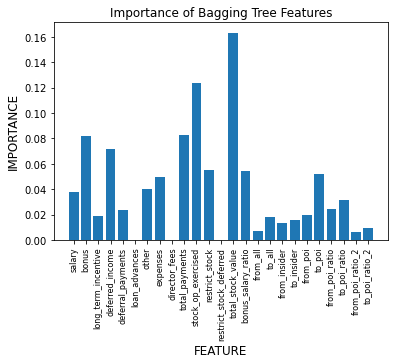

,index,Importance
0,salary,0.037442
1,bonus,0.081725
2,long_term_incentive,0.018711
3,deferred_income,0.071931
4,deferral_payments,0.023651
5,loan_advances,0.000000
6,other,0.040311
7,expenses,0.049582
8,director_fees,0.000000
9,total_payments,0.082376


In [18]:
importance = np.mean([tree.feature_importances_ for tree in bag_h.estimators_], axis=0)
df_imp = pd.DataFrame(data=importance,index= list (x_train.columns), columns=['Importance'])
df_imp = df_imp.reset_index()
plt.bar (df_imp['index'],df_imp['Importance'])
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel('FEATURE',fontsize = 12)
plt.ylabel('IMPORTANCE',fontsize = 12)
plt.title('Importance of Bagging Tree Features')
plt.show()
df_imp

The model predominately relied upon the insider's stock valuation prior to bankruptcy, annual bonus and salary, and total value of exercised stock options in detecting POIs. Conversely, the model ignored insider's deferral payments, loan advances and restricted stocks deferred in its predictions. 

For this notebook we utilize a bagging regressor to predict POI. In a seperate notebook we utilized a a logistric regression model. For the final paper we will run two additional machine learning models and compare the results for our final project.